In [45]:
import numpy as np
import secrets
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N = 200
D = 47205
TIMES = 1000

def load_libsvm_data(file_path, num_lines=200, num_features=47205):
    data = []
    labels = []

    with open(file_path, 'r') as f:
        for i in range(N):
          line = (f.readline()).split()

          y = int(line[0])
          x = torch.zeros(num_features)

          for feature in line[1:]:
            index, value = map(float, feature.split(":"))
            x[int(index) - 1] = value  # feature index start from 1

          data.append(x)
          labels.append(y)

    return torch.stack(data), torch.tensor(labels, dtype=torch.float64)


def pla(data, labels):
    x_0 = torch.tensor([1], device=device)   # x[0] = 1
    w = torch.zeros(D + 1, device=device)   # w_0 = [0, 0, ... 0]

    # sign(0) = -1
    sign_0 = torch.tensor([0], device=device)
    sign_minus_1 = torch.tensor([-1], device=device)

    consecutive_correct = 0
    target_correct = 5 * N
    updates = 0

    while consecutive_correct < target_correct:
        # random sampling
        i = secrets.randbelow(N)
        x_n = torch.cat((x_0, data[i]))
        y_n = labels[i]

        product = torch.sign(torch.dot(w, x_n))
        product = sign_minus_1 if product == sign_0 else product

        if product != y_n:
            consecutive_correct = 0
            updates += 1
            w += y_n * x_n
        else:
            consecutive_correct += 1

        # if torch.sign(torch.dot(w, x_n)) != y_n:
        #     consecutive_correct = 0
        #     updates += 1
        #     w += y_n * x_n
        # else:
        #     consecutive_correct += 1

    return updates


def pla_norm(data, labels, T_min):
    x_0 = torch.tensor([1], device=device)   # x[0] = 1
    w = torch.zeros(D + 1, device=device)   # w_0 = [0, 0, ... 0]
    func_w_t_norm = []              # record ||w_t||

    # sign(0) = -1
    sign_0 = torch.tensor([0], device=device)
    sign_minus_1 = torch.tensor([-1], device=device)

    consecutive_correct = 0
    target_correct = 5 * N
    updates = 0

    # labels_tensor = torch.tensor(labels, dtype=torch.float64)

    while consecutive_correct < target_correct:
        # random sampling
        i = secrets.randbelow(N)
        x_n = torch.cat((x_0, data[i]))
        y_n = labels[i]

        product = torch.sign(torch.dot(w, x_n))
        product = sign_minus_1 if product == sign_0 else product

        if product != y_n:
            consecutive_correct = 0
            updates += 1
            w += y_n * x_n

            # record ||w_t|| if times of update <= T_min
            if updates <= T_min:
                func_w_t_norm.append(float(torch.norm(w)))
        else:
            consecutive_correct += 1

    T_min = min(T_min, updates)

    return updates, T_min, func_w_t_norm


def pla_variant(data, labels):
    x_0 = torch.tensor([1], device=device)      # x[0] = 1
    w = torch.zeros(D + 1, device=device)     # w_0 = [0, 0, ... 0]

    # sign(0) = -1
    sign_0 = torch.tensor([0], device=device)
    sign_minus_1 = torch.tensor([-1], device=device)

    consecutive_correct = 0
    target_correct = 5 * N
    updates = 0

    while consecutive_correct < target_correct:
        # random sampling
        i = secrets.randbelow(N)
        x_n = torch.cat((x_0, data[i]))
        y_n = labels[i]

        product = torch.sign(torch.dot(w, x_n))
        product = sign_minus_1 if product == sign_0 else product

        if product != y_n:
            # update w untill correct
            while product != y_n:
                updates += 1
                w += y_n * x_n
                product = torch.sign(torch.dot(w, x_n))
                product = sign_minus_1 if product == sign_0 else product

            # reset consecutive_correct
            consecutive_correct = 1
        else:
            consecutive_correct += 1

    return updates


def experiments(data, labels):
    updates_list = []

    for _ in tqdm(range(TIMES), desc="Running pla experiments"):
        updates = pla(data, labels)
        updates_list.append(updates)

    return updates_list


def experiments_norm(data, labels):
    T_min = float('inf')
    updates_list = []
    func_w_t_norm_list =[]

    for _ in tqdm(range(TIMES), desc="Running pla_norm experiments"):
        updates, T_min, func_w_t_norm = pla_norm(data, labels, T_min)

        updates_list.append(updates)
        func_w_t_norm_list.append(func_w_t_norm)

    return updates_list, func_w_t_norm_list


def experiments_variant(data, labels):
    updates_list = []

    for _ in tqdm(range(TIMES), desc="Running pla_variant experiments"):
        updates = pla_variant(data, labels)
        updates_list.append(updates)

    return updates_list


def plot_updates(updates_list):
    plt.figure(figsize=(10, 6))
    plt.hist(updates_list, bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of Updates in PLA')
    plt.xlabel('Number of Updates')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    print(f"Median of updates: {np.median(updates_list)}")
    print(f"Mean of updates: {np.mean(updates_list)}")


def plot_norm(func_w_t_norm_list):
    plt.figure(figsize=(10, 6))
    for w_t in func_w_t_norm_list:
        plt.plot(w_t, alpha=0.2, color='blue')

    plt.title(f'∥w_t∥ as a Function of t')
    plt.xlabel('t (Number of Updates)')
    plt.ylabel('∥w_t∥ (Norm of Weight Vector)')
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    data, labels = load_libsvm_data('./rcv1_train.binary')
    data, labels = data.to(device), labels.to(device)
    if torch.cuda.is_available():
      print('GPU')
    else:
      print('CPU')
    # c = torch.tensor([[ 1, 2, 3], [-1, 1, 4]] , dtype=torch.float)
    # print(torch.norm(c))
    # w = torch.tensor([ 1, 2, 3, -1, 1, 4] , dtype=torch.float)
    # print(w)
    # print(float(torch.norm(w)))




GPU


In [34]:
updates_list = experiments(data, labels)

Running PLA experiments: 100%|██████████| 1000/1000 [05:49<00:00,  2.87it/s]


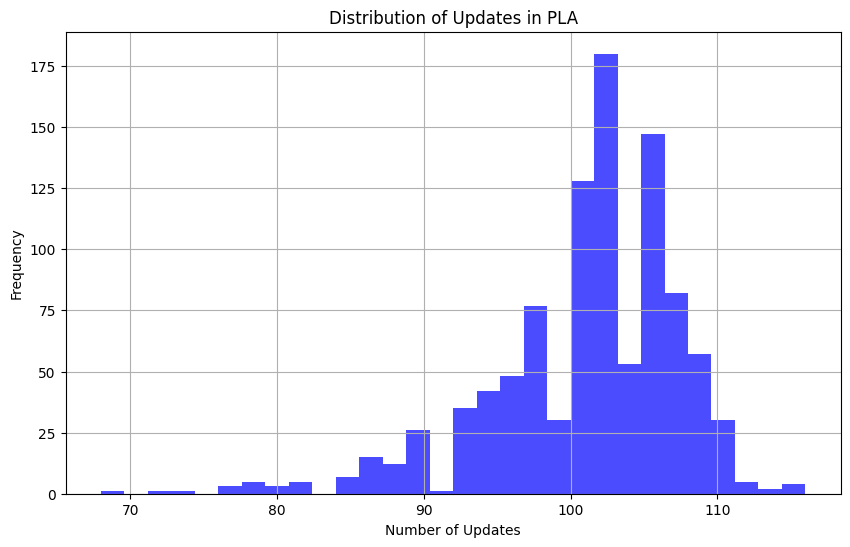

Median of updates: 102.0
Mean of updates: 100.985


In [35]:
plot_updates(updates_list)

In [38]:
updates_list = experiments_variant(data, labels)

Running pla_variant experiments: 100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


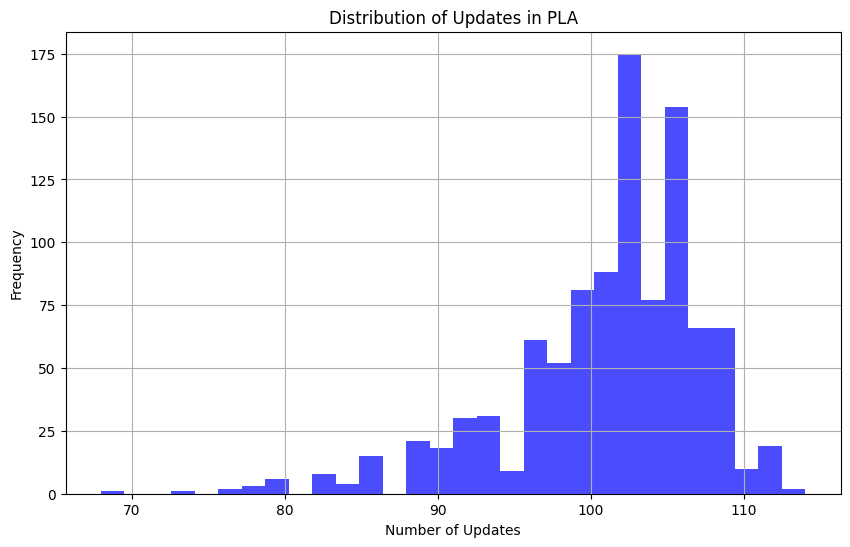

Median of updates: 102.0
Mean of updates: 101.052


In [39]:
plot_updates(updates_list)

In [42]:
w =  torch.tensor([1, 2, 3, -1, 1, 4], dtype=torch.float)
print(w)
print(float(torch.norm(w)))

tensor([ 1.,  2.,  3., -1.,  1.,  4.])
5.656854152679443


In [46]:
updates_list, func_w_t_norm_list = experiments_norm(data, labels)

Running pla_norm experiments: 100%|██████████| 1000/1000 [05:52<00:00,  2.84it/s]


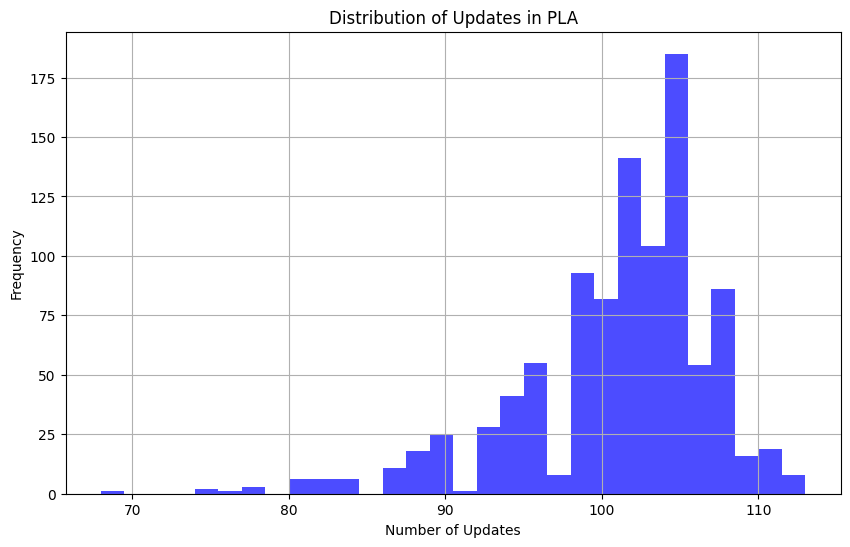

Median of updates: 102.0
Mean of updates: 100.779


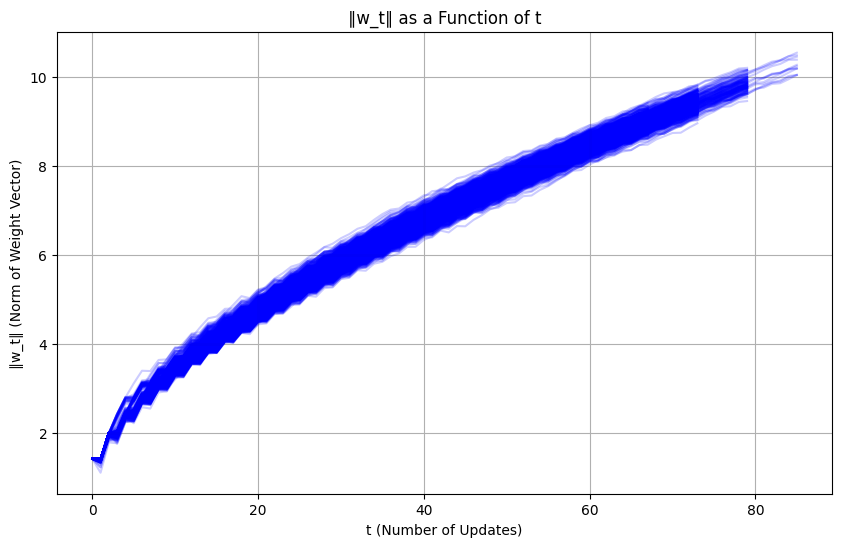

In [47]:
plot_updates(updates_list)
plot_norm(func_w_t_norm_list)